In [1]:
neg_file = open("dataset/reviews.neg",encoding="utf-8")
pos_file = open("dataset/reviews.pos",encoding="utf-8")

In [2]:
import string
pos_rev = []
neg_rev = []
for line in pos_file:
    temp_line = line.split(" ")
    temp_line[-1] = temp_line[-1].replace('\n','')
    line = " ".join(temp_line)
    line = line.lower()
    line = line.translate(str.maketrans('', '', string.punctuation))
    pos_rev.append(line)
for line in neg_file:
    temp_line = line.split(" ")
    temp_line[-1] = temp_line[-1].replace('\n','')
    line = " ".join(temp_line)
    line = line.lower()
    line = line.translate(str.maketrans('', '', string.punctuation))
    neg_rev.append(line)

In [3]:
import pandas as pd
import numpy as np
df_pos = pd.DataFrame({
    "Review":pos_rev,
    "Type":np.ones(len(pos_rev),int)
    
     })
df_neg = pd.DataFrame({
    "Review":neg_rev,
    "Type":np.zeros(len(neg_rev),int)
    
     })

In [4]:
final_df = pd.concat([df_pos,df_neg],axis=0).reset_index().drop(columns=["index"])
final_df.head(10)

,Review,Type
0,fena değil paraya göre iyi,1
1,ürün kaliteli ve çok kullanışlı kargo ya veril...,1
2,fiyatperformans karşılaştırması yaptığınızda g...,1
3,bu fiyata çok iyi,1
4,fiyat ve performans olarak gayet iyi,1
5,i̇stenileni veriyor,1
6,arzum super fön daha oncede farkli markasini k...,1
7,hepsiburadacom,1
8,i̇yi,1
9,gayet iyi bi kac gun icinde geldi hizmet cok i...,1


Text(0.5, 1.0, 'Dataset - Target distribution')

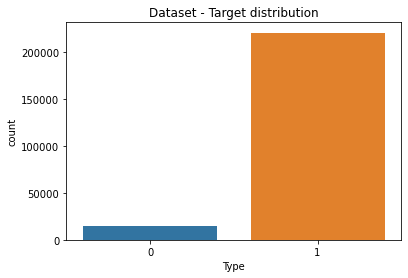

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.countplot(x = final_df['Type'])
plt.title("Dataset - Target distribution")

In [6]:
from sklearn.model_selection import train_test_split
X= final_df.Review.values
y = final_df.Type.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

Text(0.5, 1.0, 'Testset - Target distribution')

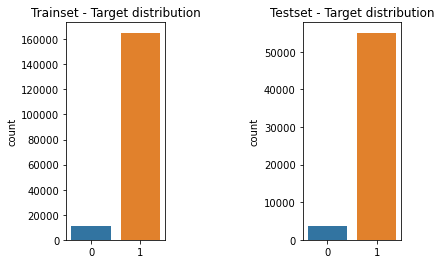

In [7]:
plt.subplot(1, 3, 1)
sns.countplot(x = y_train)
plt.title("Trainset - Target distribution")
plt.subplot(1, 3, 3)
sns.countplot(x = y_test)
plt.title("Testset - Target distribution")

In [8]:
X = final_df.Review.values

In [9]:
length=[]
for i in X:        
    length.append(len(i.split(" ")))      

In [10]:
from scipy import stats
stats.describe(length)

DescribeResult(nobs=235165, minmax=(1, 305), mean=22.48018199987243, variance=369.61146641582224, skewness=3.211954728817871, kurtosis=21.150249934531715)

Text(0.5, 1.0, 'Sentence - Length distribution')

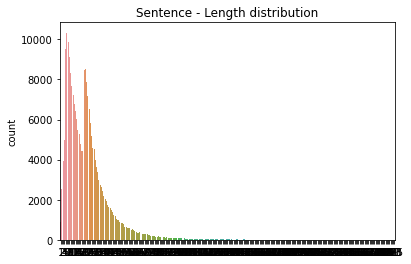

In [11]:
sns.countplot(x = length)
plt.title("Sentence - Length distribution")

In [12]:
max_features = 80000  # Number of words we are consider for whole data
maxlen = 100  # Maximum sentece length
embedding_dim=300

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_features,lower=False)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
X_train = pad_sequences(X_train, maxlen=maxlen,padding='pre')
X_test = pad_sequences(X_test, maxlen=maxlen,padding='pre')

In [15]:
embedding = open("embedding/vectors.txt",encoding="utf-8")

In [16]:
embedding_dict= {}
#Creating embedding dictionary
for i in embedding:
    line = i.split(' ')
    line[-1]=line[-1].replace('\n','')
    embedding_dict[''+line[0]]=line[1:]
    

In [17]:
len(embedding_dict)

253832

In [18]:
keys = embedding_dict.keys()
unk_token = np.zeros(300,)
#Using unk_token(average of all vetors) for the words not in embedding ectors
for i in keys:
    unk_token = unk_token + np.array(embedding_dict[i],float)
unk_token = unk_token / len(keys)    

In [19]:
# creating embedding matrix to load model
counter = 0
embedding_matrix = np.zeros((max_features + 1, 300))
embedding_matrix[0] = np.zeros(300,)
for word, i in tokenizer.word_index.items():
    if i == max_features+1:
        break
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is  None:
        embedding_vector = unk_token.tolist()#words not in embedding considered unk token
        counter = counter + 1
    embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(80001, 300)

In [21]:
print(f"Number of unk token usage: {counter}")

Number of unk token usage: 28674


In [22]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding
from keras.regularizers import L1L2

model = Sequential()
model.add(Embedding(input_dim = max_features + 1, weights =[embedding_matrix], output_dim = embedding_dim, input_length = maxlen, trainable=True))
model.add(LSTM(128, dropout = 0.1,return_sequences = True))
model.add(LSTM(128, dropout = 0.1,return_sequences = True))
model.add(LSTM(64, dropout = 0.1,return_sequences = True))
model.add(LSTM(16, dropout = 0.1))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          24000300  
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 24,406,141
Trainable params: 24,406,141
Non-trainable params: 0
____________________________________________

In [23]:
#Using micro-precision,recall,f1 score as metric.
#source https://datascience.stackexchange.com/a/45166

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [24]:
model.compile("adam", "binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])
history = model.fit(X_train, y_train, batch_size=512, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1378/1378 [==============================] - 339s 240ms/step - loss: 0.1930 - acc: 0.9369 - f1_m: 0.9655 - precision_m: 0.9441 - recall_m: 0.9915 - val_loss: 0.1234 - val_acc: 0.9562 - val_f1_m: 0.9767 - val_precision_m: 0.9663 - val_recall_m: 0.9876
Epoch 2/5
1378/1378 [==============================] - 325s 236ms/step - loss: 0.0916 - acc: 0.9686 - f1_m: 0.9833 - precision_m: 0.9766 - recall_m: 0.9903 - val_loss: 0.1342 - val_acc: 0.9553 - val_f1_m: 0.9764 - val_precision_m: 0.9599 - val_recall_m: 0.9937
Epoch 3/5
1378/1378 [==============================] - 325s 236ms/step - loss: 0.0529 - acc: 0.9833 - f1_m: 0.9911 - precision_m: 0.9878 - recall_m: 0.9945 - val_loss: 0.1638 - val_acc: 0.9523 - val_f1_m: 0.9747 - val_precision_m: 0.9653 - val_recall_m: 0.9845
Epoch 4/5
1378/1378 [==============================] - 325s 236ms/step - loss: 0.0312 - acc: 0.9910 - f1_m: 0.9952 - precision_m: 0.9931 - recall_m: 0.9973 - val_loss: 0.2133 - val_acc: 0.9509 - val_f1_m: 0.9740 - val

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    f1_m = history.history['f1_m']
    val_f1_m = history.history['val_f1_m']
    precision_m = history.history['precision_m']
    val_precision_m = history.history['val_precision_m']
    recall_m = history.history['recall_m']
    val_recall_m = history.history['val_recall_m']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(3, 2, 3)
    plt.plot(x, f1_m, 'b', label='Training F1 micro')
    plt.plot(x, val_f1_m, 'r', label='Validation F1 micro')
    plt.title('Training and validation F1 micro')
    plt.legend()
    plt.subplot(3, 2, 4)
    plt.plot(x, precision_m, 'b', label='Training Precision micro')
    plt.plot(x, val_precision_m, 'r', label='Validation Precision micro')
    plt.title('Training and validation Precision micro')
    plt.legend()
    plt.subplot(3, 2, 5)
    plt.plot(x, recall_m, 'b', label='Training Recall micro')
    plt.plot(x, val_recall_m, 'r', label='Validation Recall micro')
    plt.title('Training and validation Recall micro')
    plt.legend()

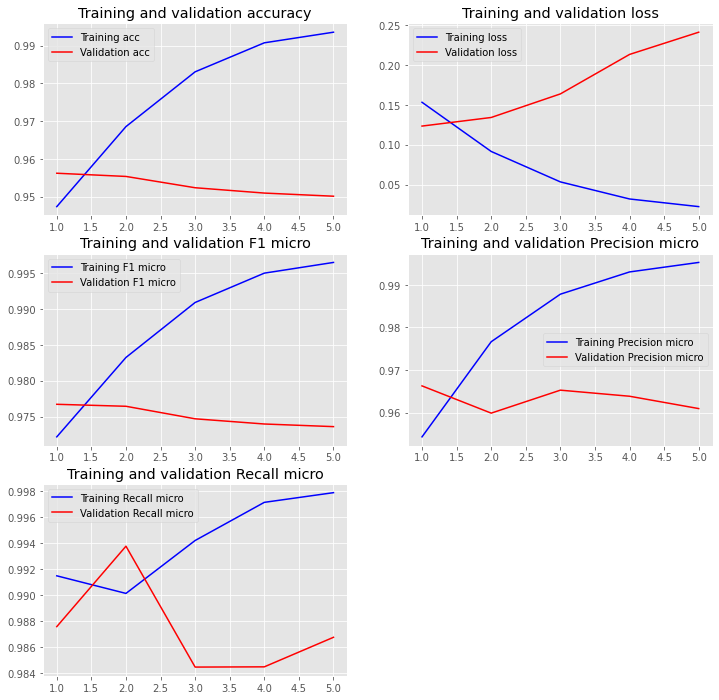

In [26]:
plot_history(history)

In [52]:
model.save_weights("model/review.h5")
#model.load_weights("model/review.h5")

In [28]:
from sklearn.metrics import classification_report
import numpy as np
y_pred = model.predict(X_test, batch_size=1024, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred>0.5))

58/58 [==============================] - 6s 91ms/step
              precision    recall  f1-score   support

           0       0.68      0.41      0.51      3739
           1       0.96      0.99      0.97     55053

    accuracy                           0.95     58792
   macro avg       0.82      0.70      0.74     58792
weighted avg       0.94      0.95      0.94     58792



In [38]:
_, X_test_for_check, _, y_test_for_check = train_test_split(X, y, test_size=0.25, random_state=1000)
def predict(n_sample):
    for i in range (0,n_sample):
        index = np.random.randint(0,len(X_test_for_check))
        print("Review :\n"+X_test_for_check[index])
        
        text = X_test_for_check[index]
        temp = []
        temp.append(text)
        temp = tokenizer.texts_to_sequences(temp)
        temp = pad_sequences(temp, maxlen=maxlen)   
        print(f"Prediction :\n\n {model.predict(temp)}")
        print("Ground Truth:\n"+str(y_test_for_check[index])+"\n\n-----------------\n\n")

In [51]:
predict(5)

Review :
ürün kısa sürede elime ulaştı montajı oldukça kolay oldu harika bir verim elde ettim küçük bağ bahçe işlerinde mükemmel olduğunu düşünüyorum i̇lk gönderimde zincir yağı ile birlikte gönderilse veya uyarı olarak zincir yağı siparişi de veriniz uyarısı olsa çok daha iyi olacağını düşünüyorum
Prediction :

 [[0.99967146]]
Ground Truth:
1

-----------------


Review :
tam anlamıyla asker saati  bunun gibi dayanıklısı yok
Prediction :

 [[0.9992347]]
Ground Truth:
1

-----------------


Review :
kokusu fena değil ancak kalıcı bir parfüm değildeodorant da keza öylehemen uçuyor sanki
Prediction :

 [[0.10399292]]
Ground Truth:
0

-----------------


Review :
1 yıldır  kullanıyorum çekim gücü ilk aldığımda iyiydi ama zamanla azaldı dik durdurmak zor oldugu icin dustu ve sapı kırıldı  en sonunda patladı ve kıvılcımlar çıkarttı attım yani 1 yıl dayandı almak isteyenlere tavsiye etmiyorum 
Prediction :

 [[0.00372043]]
Ground Truth:
1

-----------------


Review :
lastikler 3816 üretim g